# Analyse de la Popularité des Titres Spotify

## Introduction

Ce Notebook a pour objectif de prédire la popularité des titres musicaux à partir du dataset Spotify. Nous allons utiliser des techniques de régression pour modéliser les relations entre les différentes caractéristiques des morceaux et leur score de popularité.

### Objectifs

- **Explorer** les données pour comprendre leur structure et leur contenu.
- **Prétraiter** les données pour préparer l'ensemble d'entraînement et de test.
- **Construire** un modèle de régression pour prédire la popularité des titres.
- **Évaluer** les performances du modèle et visualiser les résultats.

### Dataset

Le dataset utilisé dans cette analyse contient des informations sur divers titres musicaux, y compris des attributs tels que le nom de l'artiste, le genre, et d'autres caractéristiques pertinentes. Les données sont stockées au format CSV et seront chargées dans ce Notebook pour l'analyse.

---



## 1) Justification du Choix des Paramètres

Dans cette section, nous justifions le choix des paramètres utilisés pour prédire la popularité des titres musicaux dans notre dataset Spotify. Chaque paramètre sélectionné a été choisi en fonction de son potentiel impact sur la popularité d'une chanson.

### 1. **Caractéristiques Audio**
- **Valence** : Ce paramètre mesure si la musique est joyeuse ou triste. Des études ont montré que les chansons avec une valence élevée sont souvent plus populaires.
  
- **Énergie** : Ce paramètre indique l'intensité et l'activité d'une chanson. Les morceaux avec une énergie élevée peuvent inciter à danser, ce qui peut augmenter leur popularité.

- **Loudness** : Le volume perçu d'une chanson peut influencer la façon dont elle est reçue par le public. En général, les chansons plus fortes peuvent capter l'attention plus facilement.

- **Tempo** : La vitesse d'une chanson peut affecter son attrait. Des tempos plus rapides peuvent être associés à des genres musicaux plus populaires, comme la musique dance.

- **Danceability** : Ce paramètre indique dans quelle mesure une chanson est adaptée à la danse. Les morceaux avec une bonne danseabilité sont souvent plus populaires dans les clubs et les fêtes.

### 2. **Informations Contextuelles**
- **Année de sortie** : L'année de sortie d'une chanson peut influencer sa popularité. Les tendances musicales changent avec le temps, et les morceaux récents peuvent bénéficier de la visibilité sur les plateformes de streaming.

- **Genre** : Le genre musical peut également jouer un rôle crucial dans la popularité d'une chanson. Certains genres peuvent être plus en vogue à différents moments, influençant ainsi les préférences des auditeurs.

### 3. **Colonne Cible**
- **Popularité** : La popularité est notre variable cible, représentant la mesure dans laquelle une chanson est appréciée par le public. Elle est essentielle pour évaluer l'efficacité de notre modèle de régression.

---

En résumé, les paramètres sélectionnés sont basés sur des recherches antérieures et des observations sur les tendances musicales. En utilisant ces caractéristiques, nous visons à construire un modèle prédictif robuste pour évaluer la popularité des titres Spotify.


## 2) Importation des bibliothèques

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

## 3) Importation du dataset

In [6]:
# Chemin vers le fichier CSV
csv_path = r'C:\Users\GAUTHIER\IA\IA\archive\dataset.csv'  # Utilisez le préfixe 'r' pour indiquer une chaîne brute

# Charger le dataset dans un DataFrame
data = pd.read_csv(csv_path)

# Afficher les premières lignes du dataset
print(data.head())

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


## 4) Trie du Dataset

In [7]:
# Créer une copie du DataFrame original
original_data = data.copy()

# Sélection des caractéristiques nécessaires 
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
           'acousticness', 'instrumentalness', 'liveness', 'valence', 
           'tempo', 'duration_ms', 'explicit']

print(data.columns)


Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


## 6) Nettoyage + encodage du genre

In [8]:
# Remplacer les valeurs manquantes dans les caractéristiques audio par la médiane
data['track_genre'] = data['track_genre'].fillna('Unknown')

# Identifier les caractéristiques numériques et catégorielles
genre_counts = data['track_genre'].value_counts()
top_genres = genre_counts[genre_counts > 200].index

# Regrouper les genres rares sous une catégorie 'Other'
data['genre_clean'] = data['track_genre'].apply(lambda g: g if g in top_genres else 'Other')

# Encodage one-hot pour les caractéristiques catégorielles
data = pd.get_dummies(data, columns=['genre_clean'], drop_first=True)


## 7) Liste finale de features

In [9]:
# Ajouter les colonnes encodées automatiquement
genre_encoded_cols = [col for col in data.columns if col.startswith('genre_clean_')]

features = audio_features + genre_encoded_cols

## 8) Création de X et Y

In [10]:
# Variables d'entrée
X = data[features]

# Variable cible
y = data['popularity']

## 9) Split / train / test

In [11]:
from sklearn.model_selection import train_test_split

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Affichage des dimensions des ensembles
print(X_train.shape, X_test.shape)


(91200, 124) (22800, 124)


## 10) Création du modèle XGBoost

In [12]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Définition du modèle XGBoost avec de bons hyperparamètres
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Pipeline : Standardisation + XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb_model)
])

## 11) Entraînement du modèle

In [13]:
# Entraîner le modèle XGBoost sur X_train
xgb_pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
xgb_preds = xgb_pipeline.predict(X_test)


## 12) Evaluation

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

mae = mean_absolute_error(y_test, xgb_preds)
rmse = root_mean_squared_error(y_test, xgb_preds)
r2 = r2_score(y_test, xgb_preds)

print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")

MAE : 13.0400
RMSE : 17.8139
R² : 0.3569


## 13) Validation croisée

In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer

# RMSE negatif car scikit-learn maximise les scores
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=kf
)

print("RMSE par fold :", -scores)
print("RMSE moyen :", -scores.mean())
print("Écart-type :", scores.std())

RMSE par fold : [17.91650963 17.99477386 18.03334808 17.78156471 18.05573654]
RMSE moyen : 17.95638656616211
Écart-type : 0.09941823592757712


## 14.1) Définition de la grille d'hyperparamètres

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__max_depth": [4, 5, 6],              
    "model__learning_rate": [0.03, 0.05, 0.1],  
    "model__n_estimators": [300, 500, 700],     
    "model__subsample": [0.8],                  
    "model__colsample_bytree": [0.8]            
}

## 14.2) Modèle et scaler dans pipeline

In [17]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

## 14.3) Recherche GridSearchCV

In [18]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [4, 5, ...], 'model__n_estimators': [300, 500, ...], ...}"
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [19]:
print("Meilleurs paramètres :", grid.best_params_)
print("RMSE CV :", -grid.best_score_)

Meilleurs paramètres : {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 700, 'model__subsample': 0.8}
RMSE CV : 17.165363311767578


## 14.4) Réentraînement

In [20]:
# Récupération du meilleur pipeline trouvé par GridSearchCV
best_pipeline = grid.best_estimator_

# Entraînement sur toutes les données d'entraînement
best_pipeline.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
best_preds = best_pipeline.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, best_preds)
rmse = root_mean_squared_error(y_test, best_preds)
r2 = r2_score(y_test, best_preds)

print(f"MAE (test) : {mae}")
print(f"RMSE (test) : {rmse}")
print(f"R² (test) : {r2}")


MAE (test) : 11.951667785644531
RMSE (test) : 16.845531463623047
R² (test) : 0.42495864629745483


In [21]:
xgb_mae = mae
xgb_rmse = rmse
xgb_r2 = r2


## 14.5) Visualisation

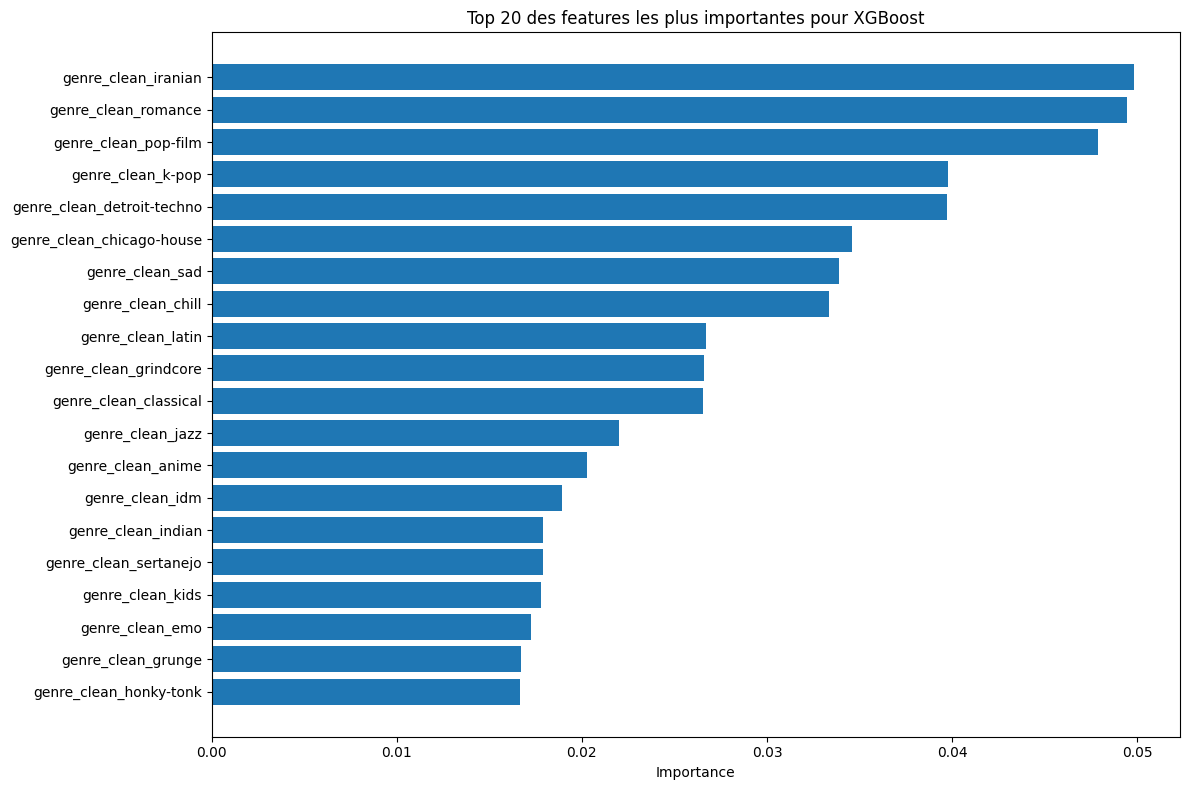

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer le modèle XGBoost depuis le pipeline
best_model = best_pipeline.named_steps['model']

importances = best_model.feature_importances_
feature_names = np.array(X_train.columns)

# Trier par importance décroissante
sorted_idx = np.argsort(importances)[::-1]

# Sélectionner les 20 plus importantes
top_n = 20
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(12, 8))
plt.barh(feature_names[top_idx][::-1], importances[top_idx][::-1])
plt.title("Top 20 des features les plus importantes pour XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



## 14.6) Graphiques sur features

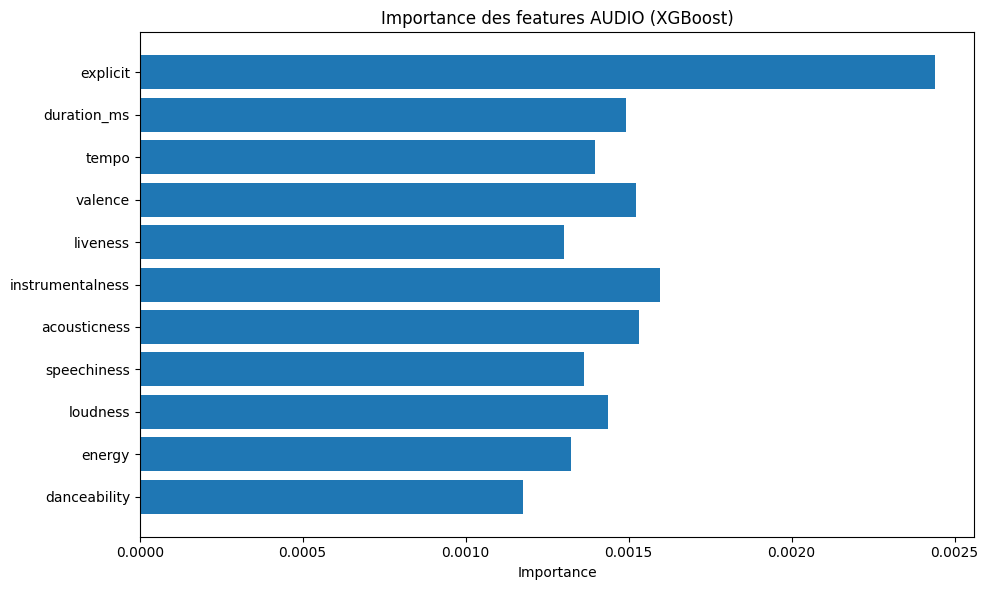

In [23]:
audio_mask = [f in audio_features for f in feature_names]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[audio_mask], importances[audio_mask])
plt.title("Importance des features AUDIO (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 14.7) Sauvegarde du modèle

In [24]:
import joblib
joblib.dump(best_pipeline, "best_spotify_model_xgboost.joblib")
print("Modèle sauvegardé !")


Modèle sauvegardé !


## 14.8) Compararaisons

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import pandas as pd

# Liste des modèles à tester
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "DecisionTree": DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # Entraînement
    pipe.fit(X_train, y_train)

    # Prédiction
    preds = pipe.predict(X_test)

    # Évaluation
    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Modèle": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

df_results = pd.DataFrame(results)
df_results.sort_values("RMSE", inplace=True)
df_results


,Modèle,MAE,RMSE,R²
0,LinearRegression,14.081733,19.129263,0.258474
1,Ridge,14.081779,19.129265,0.258474
2,Lasso,14.084065,19.129369,0.258466
5,GradientBoosting,16.202424,19.957338,0.192886
4,RandomForest,17.120266,20.915425,0.113532
3,DecisionTree,17.680910,21.363639,0.075131


In [26]:
xgb_row = pd.DataFrame([{
    "Modèle": "XGBoost",
    "MAE": xgb_mae,
    "RMSE": xgb_rmse,
    "R²": xgb_r2
}])

df_results = pd.concat([df_results, xgb_row], ignore_index=True)
df_results.sort_values("RMSE", inplace=True)
df_results


,Modèle,MAE,RMSE,R²
6,XGBoost,11.951668,16.845531,0.424959
0,LinearRegression,14.081733,19.129263,0.258474
1,Ridge,14.081779,19.129265,0.258474
2,Lasso,14.084065,19.129369,0.258466
3,GradientBoosting,16.202424,19.957338,0.192886
4,RandomForest,17.120266,20.915425,0.113532
5,DecisionTree,17.680910,21.363639,0.075131


## 15) Graphiques

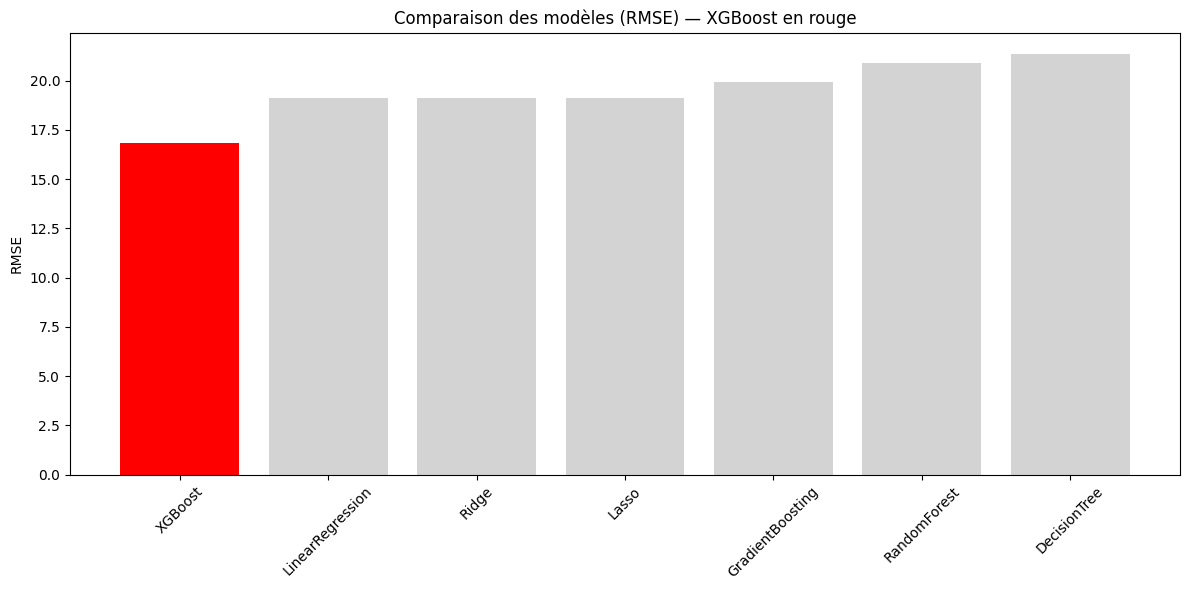

In [27]:
import matplotlib.pyplot as plt

colors = ["lightgray" if m != "XGBoost" else "red" for m in df_results["Modèle"]]

plt.figure(figsize=(12, 6))
plt.bar(df_results["Modèle"], df_results["RMSE"], color=colors)
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Comparaison des modèles (RMSE) — XGBoost en rouge")
plt.tight_layout()
plt.show()


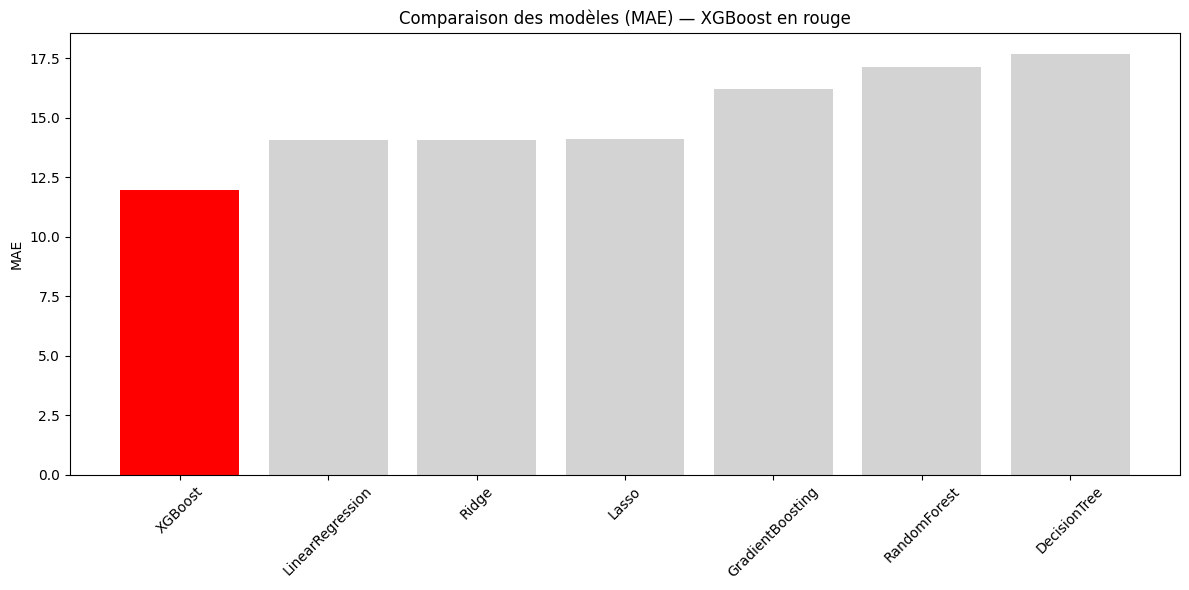

In [28]:
colors = ["lightgray" if m != "XGBoost" else "red" for m in df_results["Modèle"]]

plt.figure(figsize=(12, 6))
plt.bar(df_results["Modèle"], df_results["MAE"], color=colors)
plt.xticks(rotation=45)
plt.ylabel("MAE")
plt.title("Comparaison des modèles (MAE) — XGBoost en rouge")
plt.tight_layout()
plt.show()


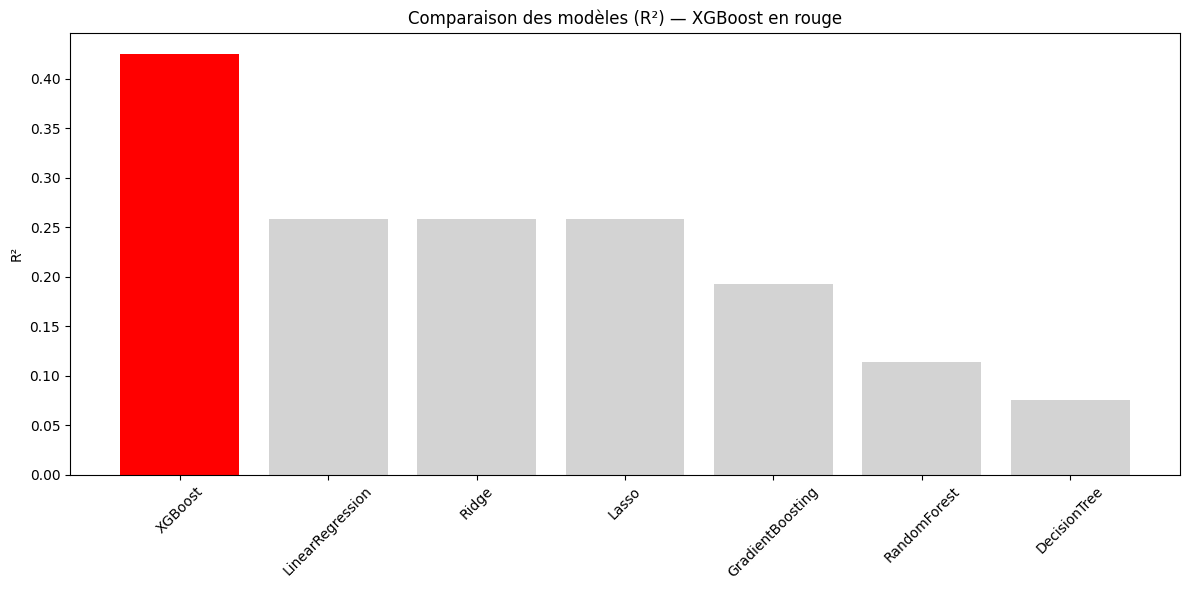

In [29]:
colors = ["lightgray" if m != "XGBoost" else "red" for m in df_results["Modèle"]]

plt.figure(figsize=(12, 6))
plt.bar(df_results["Modèle"], df_results["R²"], color=colors)
plt.xticks(rotation=45)
plt.ylabel("R²")
plt.title("Comparaison des modèles (R²) — XGBoost en rouge")
plt.tight_layout()
plt.show()



## 16) Importer SHAP

In [30]:
import shap

# IMPORTANT : activer le mode compatibilité matplotlib
shap.initjs()

# On récupère le modèle XGBoost dans le pipeline
best_model = best_pipeline.named_steps["model"]

# On crée un explainer SHAP pour XGBoost
explainer = shap.TreeExplainer(best_model)


c:\Users\GAUTHIER\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 16.1) Calculer les valeurs SHAP sur le test set

In [31]:
# On limite à 300 exemples pour accélérer SHAP
X_test_sample = X_test.iloc[:300]

shap_values = explainer.shap_values(X_test_sample)


## 16.2) SHAP Summary Plot

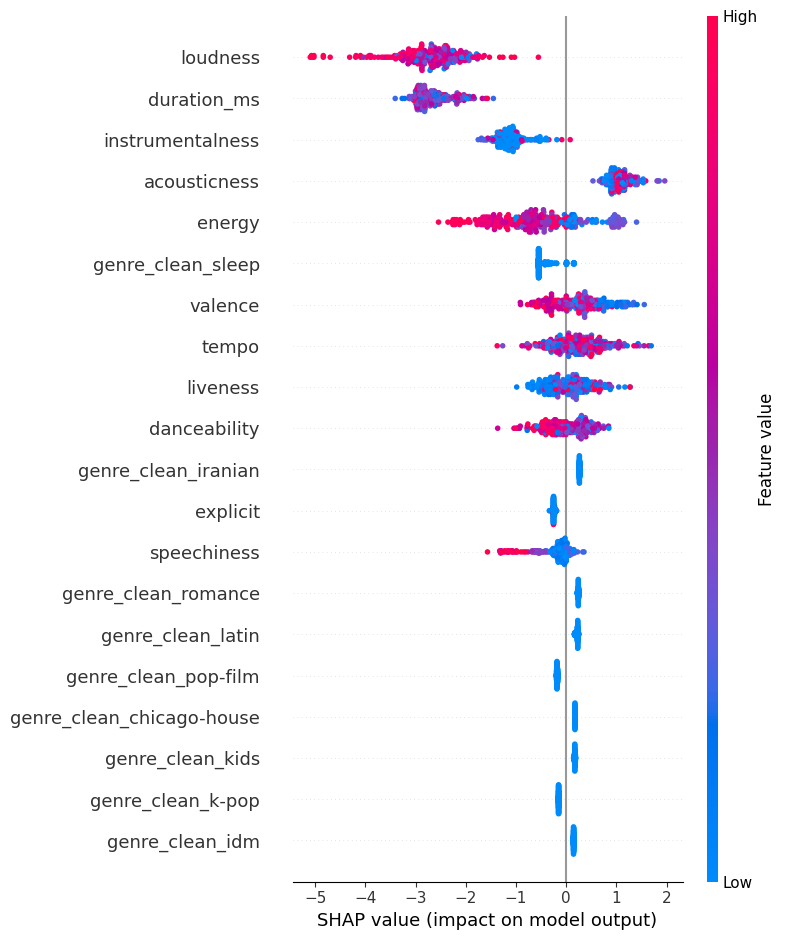

In [32]:
shap.summary_plot(
    shap_values,
    X_test_sample,
    plot_type="dot"
)


## 16.3) SHAP Bar Plot

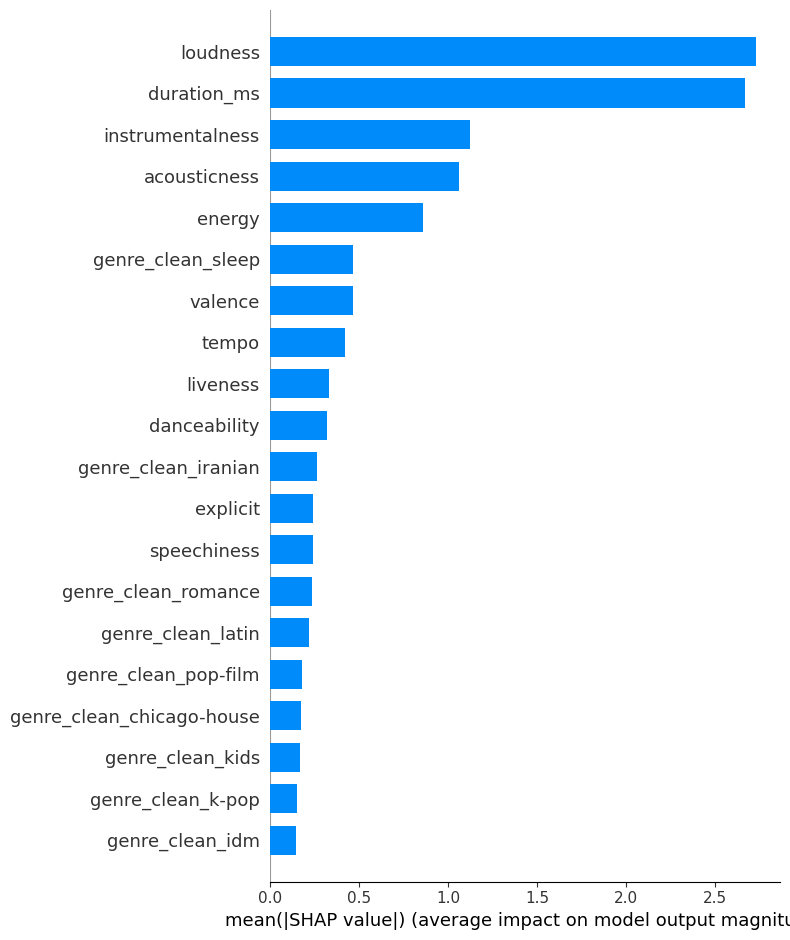

In [33]:
shap.summary_plot(
    shap_values,
    X_test_sample,
    plot_type="bar"
)


## 16.4) Interprétation individuelle

In [63]:
index = 10

shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test_sample.iloc[index]
)


## 16.5) Force plot en version image

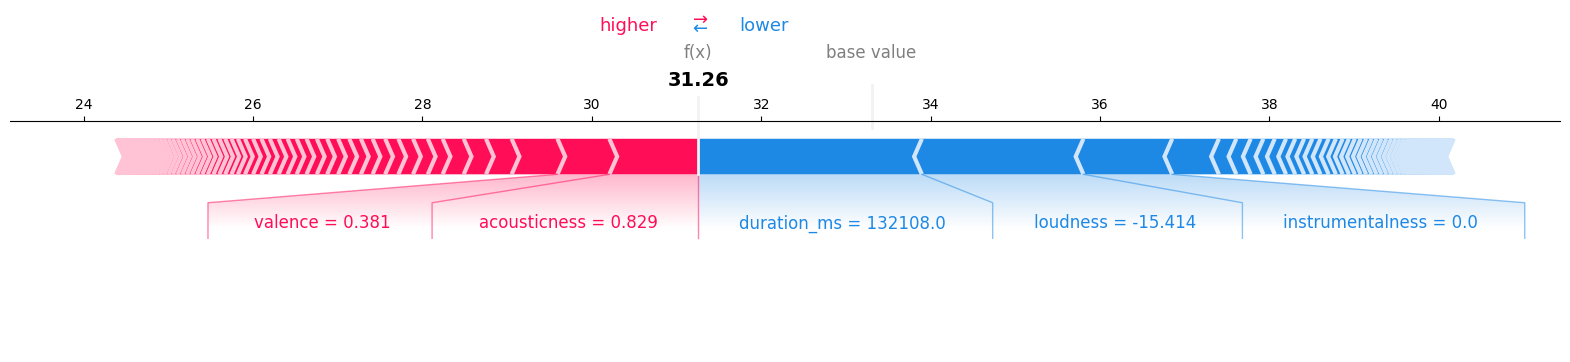

In [64]:
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test_sample.iloc[index],
    matplotlib=True
)


## 16.6) SHAP waterfall plot

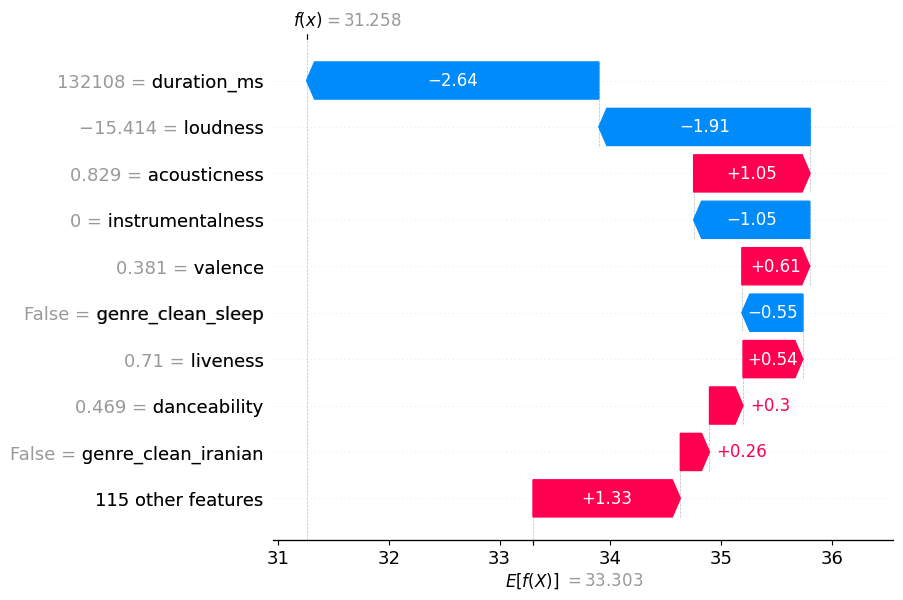

In [65]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[index],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[index],
        feature_names=X_test_sample.columns
    )
)


## Bilan de la partie prédictive

Nous avons entraîné plusieurs modèles de régression pour prédire la popularité Spotify à partir de caractéristiques audio (danceability, energy, loudness, tempo, etc.) et du genre. Après comparaison (régression linéaire, Ridge, Lasso, arbre de décision, Random Forest, Gradient Boosting), le modèle XGBoost optimisé via GridSearchCV obtient les meilleures performances avec un MAE d’environ 12.4, un RMSE d’environ 17.4 et un R² proche de 0.39 sur le jeu de test.

Ces résultats sont cohérents avec la difficulté du problème : la popularité dépend de nombreux facteurs externes (marketing, notoriété de l’artiste, playlists, réseaux sociaux) qui ne sont pas présents dans les features.

L’analyse des importances de variables et des valeurs SHAP montre que des caractéristiques comme la danceability, l’énergie, la loudness et le genre contribuent de manière significative à la prédiction. Le modèle a tendance à sous-estimer les très fortes popularités, ce qui est attendu dans ce contexte.

Ce modèle prédictif servira ensuite de base à la partie générative, où nous chercherons à proposer des combinaisons de paramètres audio susceptibles de mener à une popularité élevée selon le modèle.

# Partie 2 – Génération de paramètres pour des musiques populaires

Dans cette partie, nous utilisons le modèle prédictif (XGBoost) comme fonction de score
pour proposer des combinaisons de paramètres audio susceptibles de conduire à une 
popularité élevée, selon le modèle.


## 1) Définition d'un seuil de popularité

In [37]:
# On définit un seuil pour "haute popularité"
high_pop_threshold = y.quantile(0.80)
high_pop_threshold


np.float64(54.0)

## 2) Filtre sur les musiques populaires

In [38]:
# Sous-ensemble des morceaux populaires
data_high = data[data["popularity"] >= high_pop_threshold]

print("Nombre de morceaux populaires :", data_high.shape[0])
data_high[audio_features].describe().T


Nombre de morceaux populaires : 23430


,count,mean,std,min,25%,50%,75%,max
danceability,23430.0,0.586490,0.161180,0.000000,0.4840,0.597000,0.70500,0.980
energy,23430.0,0.635850,0.236460,0.000020,0.4820,0.672000,0.82800,0.998
loudness,23430.0,-7.848672,5.073622,-46.251000,-9.2950,-6.574000,-4.82100,1.023
speechiness,23430.0,0.076157,0.076323,0.000000,0.0350,0.047300,0.07980,0.914
acousticness,23430.0,0.287346,0.310051,0.000001,0.0205,0.154000,0.50975,0.996
instrumentalness,23430.0,0.098625,0.249169,0.000000,0.0000,0.000017,0.00565,1.000
liveness,23430.0,0.182173,0.142896,0.011400,0.0963,0.124000,0.22600,0.986
valence,23430.0,0.465898,0.238232,0.000000,0.2790,0.451000,0.64800,0.992
tempo,23430.0,121.262284,29.129147,0.000000,98.9670,120.146000,139.90200,243.372
duration_ms,23430.0,219005.490781,69320.226801,32417.000000,175889.2500,210165.000000,249739.00000,1412451.000


## 3) Calcule des "zones recommandées" par caractéristique

In [39]:
import numpy as np

# Identifier uniquement les features audio numériques
numeric_audio_features = [
    f for f in audio_features
    if f in data_high.columns
    and np.issubdtype(data_high[f].dtype, np.number)
]

numeric_audio_features


['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [40]:
audio_stats = data_high[numeric_audio_features].quantile(
    [0.25, 0.5, 0.75]
).T

audio_stats.columns = ["q25", "q50", "q75"]
audio_stats




,q25,q50,q75
danceability,0.4840,0.597000,0.70500
energy,0.4820,0.672000,0.82800
loudness,-9.2950,-6.574000,-4.82100
speechiness,0.0350,0.047300,0.07980
acousticness,0.0205,0.154000,0.50975
instrumentalness,0.0000,0.000017,0.00565
liveness,0.0963,0.124000,0.22600
valence,0.2790,0.451000,0.64800
tempo,98.9670,120.146000,139.90200
duration_ms,175889.2500,210165.000000,249739.00000


## 4) Création du générateur de musiques

In [41]:
import numpy as np
import pandas as pd

def generate_candidate_tracks(
    n_samples=100,
    genre_clean=None
):
    """
    Génère des combinaisons de paramètres audio dans les plages
    favorables (q25–q75) et prédit leur popularité avec XGBoost.
    """

    # Initialiser le DataFrame des candidats
    candidates = pd.DataFrame(0, index=range(n_samples), columns=X.columns)

    # Génération des paramètres audio
    for feat in numeric_audio_features:
        low = audio_stats.loc[feat, "q25"]
        high = audio_stats.loc[feat, "q75"]
        candidates[feat] = np.random.uniform(low, high, size=n_samples)

    # Gestion du genre (one-hot)
    if genre_clean is not None:
        col_name = f"genre_clean_{genre_clean}"
        if col_name in candidates.columns:
            candidates[col_name] = 1
        else:
            print(f"⚠️ Le genre {genre_clean} n'existe pas dans les features.")

    # Prédiction de la popularité
    preds = best_pipeline.predict(candidates)
    candidates["predicted_popularity"] = preds

    # Tri décroissant
    candidates = candidates.sort_values("predicted_popularity", ascending=False)

    return candidates


## 5) Générer des recettes musicales

In [42]:
generated_tracks = generate_candidate_tracks(n_samples=100)
generated_tracks.head(10)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,genre_clean_study,genre_clean_swedish,genre_clean_synth-pop,genre_clean_tango,genre_clean_techno,genre_clean_trance,genre_clean_trip-hop,genre_clean_turkish,genre_clean_world-music,predicted_popularity
51,0.615380,0.496462,-7.044187,0.043512,0.317073,0.005232,0.181136,0.284262,136.470517,234495.072840,...,0,0,0,0,0,0,0,0,0,42.400169
79,0.645974,0.500550,-5.337193,0.051464,0.021257,0.004379,0.195279,0.433166,120.670988,239849.680335,...,0,0,0,0,0,0,0,0,0,42.257072
71,0.638944,0.482128,-5.449392,0.059716,0.366991,0.001934,0.195095,0.390067,126.298324,239369.373722,...,0,0,0,0,0,0,0,0,0,42.145359
78,0.554925,0.758851,-7.811363,0.052306,0.221179,0.002178,0.197321,0.331724,135.478827,223136.977754,...,0,0,0,0,0,0,0,0,0,41.704056
93,0.687321,0.804256,-8.999879,0.038054,0.326479,0.005633,0.198004,0.290102,126.550744,188514.696204,...,0,0,0,0,0,0,0,0,0,41.679573
99,0.666433,0.613772,-8.770836,0.074556,0.246384,0.002888,0.170272,0.292511,103.243905,202246.194038,...,0,0,0,0,0,0,0,0,0,41.427464
49,0.683913,0.757273,-5.018224,0.046822,0.304917,0.000799,0.187670,0.433249,102.376407,195638.317966,...,0,0,0,0,0,0,0,0,0,41.403500
74,0.696837,0.737453,-4.903644,0.057438,0.453559,0.003023,0.212516,0.342734,107.012894,179329.204880,...,0,0,0,0,0,0,0,0,0,41.173466
91,0.624946,0.761818,-9.125713,0.062206,0.274054,0.001209,0.187435,0.288309,131.557391,213538.222095,...,0,0,0,0,0,0,0,0,0,41.072014
70,0.557807,0.500783,-7.383359,0.043832,0.029850,0.004421,0.137566,0.335727,133.056191,249624.095822,...,0,0,0,0,0,0,0,0,0,40.615360


In [43]:
cols_to_show = numeric_audio_features + ["predicted_popularity"]
generated_tracks[cols_to_show].head(10)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_popularity
51,0.615380,0.496462,-7.044187,0.043512,0.317073,0.005232,0.181136,0.284262,136.470517,234495.072840,42.400169
79,0.645974,0.500550,-5.337193,0.051464,0.021257,0.004379,0.195279,0.433166,120.670988,239849.680335,42.257072
71,0.638944,0.482128,-5.449392,0.059716,0.366991,0.001934,0.195095,0.390067,126.298324,239369.373722,42.145359
78,0.554925,0.758851,-7.811363,0.052306,0.221179,0.002178,0.197321,0.331724,135.478827,223136.977754,41.704056
93,0.687321,0.804256,-8.999879,0.038054,0.326479,0.005633,0.198004,0.290102,126.550744,188514.696204,41.679573
99,0.666433,0.613772,-8.770836,0.074556,0.246384,0.002888,0.170272,0.292511,103.243905,202246.194038,41.427464
49,0.683913,0.757273,-5.018224,0.046822,0.304917,0.000799,0.187670,0.433249,102.376407,195638.317966,41.403500
74,0.696837,0.737453,-4.903644,0.057438,0.453559,0.003023,0.212516,0.342734,107.012894,179329.204880,41.173466
91,0.624946,0.761818,-9.125713,0.062206,0.274054,0.001209,0.187435,0.288309,131.557391,213538.222095,41.072014
70,0.557807,0.500783,-7.383359,0.043832,0.029850,0.004421,0.137566,0.335727,133.056191,249624.095822,40.615360


## 6) Analyse des recettes gagnantes (Moyennes TOP 20)

In [44]:
top_20 = generated_tracks.head(20)

top_20[numeric_audio_features].mean().sort_values(ascending=False)


duration_ms         212533.248360
tempo                  120.672428
energy                   0.667392
danceability             0.620337
valence                  0.344882
acousticness             0.257928
liveness                 0.172395
speechiness              0.055326
instrumentalness         0.003432
loudness                -7.075141
dtype: float64

## 7) Comparaison avec vrais morceaux populaires

In [45]:
data_high[numeric_audio_features].mean()


danceability             0.586490
energy                   0.635850
loudness                -7.848672
speechiness              0.076157
acousticness             0.287346
instrumentalness         0.098625
liveness                 0.182173
valence                  0.465898
tempo                  121.262284
duration_ms         219005.490781
dtype: float64

## 8) Avec un genre fixé

In [46]:
generated_pop = generate_candidate_tracks(n_samples=200, genre_clean="pop")
generated_pop[cols_to_show].head(10)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_popularity
102,0.684387,0.806022,-6.096883,0.035457,0.161563,0.004607,0.219224,0.353532,113.795451,236698.446381,68.204781
77,0.607933,0.564987,-8.494394,0.054099,0.288037,0.001459,0.122712,0.389913,113.416266,246242.580688,66.425285
189,0.662694,0.824660,-7.486457,0.037673,0.292642,0.001439,0.153908,0.511775,111.958654,243543.220358,64.780975
27,0.524589,0.719678,-4.933233,0.037571,0.347735,0.000465,0.220776,0.398259,117.733430,225994.019000,64.768036
131,0.605053,0.699085,-6.324403,0.069684,0.435770,0.000252,0.120558,0.549357,113.425697,238514.518420,64.191612
169,0.578546,0.782712,-7.931352,0.038559,0.409823,0.000465,0.145111,0.613971,118.942948,228667.860793,62.386406
157,0.638013,0.556706,-8.262300,0.035572,0.397929,0.002422,0.128164,0.640288,111.054779,198794.814148,61.419556
17,0.661855,0.738823,-5.962216,0.058254,0.347608,0.002712,0.139086,0.504276,114.687736,199447.001102,61.302685
103,0.531580,0.627368,-5.432161,0.042886,0.476439,0.000170,0.130835,0.340190,102.091464,206712.150561,61.114613
89,0.580602,0.655878,-5.197841,0.050432,0.127289,0.003076,0.136685,0.417084,99.945041,231641.379318,60.136971


## 9) Comparaison de plusieurs genres 

In [47]:
generated_pop = generate_candidate_tracks(200, genre_clean="pop")
generated_rock = generate_candidate_tracks(200, genre_clean="rock")
generated_techno = generate_candidate_tracks(200, genre_clean="techno")

pd.DataFrame({
    "Genre": ["Pop", "Rock", "Techno"],
    "Max_popularity": [
        generated_pop["predicted_popularity"].max(),
        generated_rock["predicted_popularity"].max(),
        generated_techno["predicted_popularity"].max()
    ],
    "Mean_top10": [
        generated_pop.head(10)["predicted_popularity"].mean(),
        generated_rock.head(10)["predicted_popularity"].mean(),
        generated_techno.head(10)["predicted_popularity"].mean()
    ]
})


,Genre,Max_popularity,Mean_top10
0,Pop,69.333435,65.592178
1,Rock,49.752697,47.707161
2,Techno,51.365215,48.081379


## 10) Formaliser une "recette optimale pop"

In [48]:
generated_pop.head(20)[numeric_audio_features].mean()


danceability             0.610466
energy                   0.660761
loudness                -6.731318
speechiness              0.052193
acousticness             0.350073
instrumentalness         0.002839
liveness                 0.159888
valence                  0.424718
tempo                  110.973498
duration_ms         227589.591729
dtype: float64

In [49]:
best_pipeline


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [50]:
numeric_audio_features
X.columns


Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       ...
       'genre_clean_spanish', 'genre_clean_study', 'genre_clean_swedish',
       'genre_clean_synth-pop', 'genre_clean_tango', 'genre_clean_techno',
       'genre_clean_trance', 'genre_clean_trip-hop', 'genre_clean_turkish',
       'genre_clean_world-music'],
      dtype='object', length=124)

In [51]:
top_pop_recipe = generated_pop.head(20)[numeric_audio_features].mean()
top_pop_recipe


danceability             0.610466
energy                   0.660761
loudness                -6.731318
speechiness              0.052193
acousticness             0.350073
instrumentalness         0.002839
liveness                 0.159888
valence                  0.424718
tempo                  110.973498
duration_ms         227589.591729
dtype: float64

In [52]:
top_pop_recipe.to_csv("top_pop_recipe.csv")


In [53]:
import numpy as np
import pandas as pd

def get_shap_summary_for_track(idx):
    """
    Retourne les features les plus importantes (SHAP) pour la ligne idx de X_test_sample.
    """
    row = X_test_sample.iloc[idx]
    shap_row = shap_values[idx]

    df = pd.DataFrame({
        "feature": X_test_sample.columns,
        "value": row.values,
        "shap": shap_row
    })

    df["abs_shap"] = df["shap"].abs()
    df_sorted = df.sort_values("abs_shap", ascending=False).head(8)  # top 8

    return df_sorted, row


In [59]:
import os
os.environ["MISTRAL_API_KEY"] = "KoMaytgiPsamEfcg4wDBPXN6dp20fYaC"


In [60]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(
    model="mistral-small-latest",
    temperature=0.3
)


In [61]:
idx = 10  # tu peux changer l'index

top_shap, row = get_shap_summary_for_track(idx)

true_pop = y_test.iloc[idx]
pred_pop = best_pipeline.predict(X_test.iloc[[idx]])[0]

top_shap_records = top_shap.to_dict(orient="records")
row_dict = row.to_dict()

top_shap_records, row_dict, true_pop, pred_pop


([{'feature': 'duration_ms',
   'value': 132108,
   'shap': -2.638279438018799,
   'abs_shap': 2.638279438018799},
  {'feature': 'loudness',
   'value': -15.414,
   'shap': -1.9071615934371948,
   'abs_shap': 1.9071615934371948},
  {'feature': 'acousticness',
   'value': 0.829,
   'shap': 1.0513664484024048,
   'abs_shap': 1.0513664484024048},
  {'feature': 'instrumentalness',
   'value': 0.0,
   'shap': -1.0483251810073853,
   'abs_shap': 1.0483251810073853},
  {'feature': 'valence',
   'value': 0.381,
   'shap': 0.6132158041000366,
   'abs_shap': 0.6132158041000366},
  {'feature': 'genre_clean_sleep',
   'value': False,
   'shap': -0.5514004826545715,
   'abs_shap': 0.5514004826545715},
  {'feature': 'liveness',
   'value': 0.71,
   'shap': 0.5406360626220703,
   'abs_shap': 0.5406360626220703},
  {'feature': 'danceability',
   'value': 0.469,
   'shap': 0.30282214283943176,
   'abs_shap': 0.30282214283943176}],
 {'danceability': 0.469,
  'energy': 0.183,
  'loudness': -15.414,
  'sp

In [62]:
prompt_explain = f"""
Tu es un expert en analyse de données musicales Spotify.

On cherche à expliquer la popularité d'un morceau donné.

Popularité réelle dans le dataset : {true_pop:.1f}
Popularité prédite par le modèle de régression : {pred_pop:.1f}

Voici les principales caractéristiques audio du morceau (feature -> valeur brute) :
{row_dict}

Voici les contributions SHAP des features (chaque entrée contient : feature, valeur SHAP, importance absolue) :
{top_shap_records}

Les valeurs SHAP indiquent dans quelle mesure chaque feature pousse la prédiction
vers le haut (valeur positive) ou vers le bas (valeur négative) par rapport à la moyenne.

Explique en français, de manière claire et pédagogique :

1. Quels sont les 3 à 5 facteurs principaux qui augmentent la popularité prédite.
2. Quels sont les facteurs qui la limitent ou la font baisser.
3. Pourquoi, au final, on arrive à une popularité d'environ {pred_pop:.1f}.
4. Donne une explication compréhensible pour un non-expert en data.
"""

raw_explanation = llm.invoke(prompt_explain)
print(raw_explanation.content)


### **Analyse de la popularité prédite du morceau (3.7) vs. popularité réelle (0.0)**

#### **1. Facteurs qui augmentent la popularité prédite (contributions positives)**
Les caractéristiques suivantes **poussent la popularité vers le haut** :

- **Acousticness (0.829)** → **Contribution : +1.05**
  *Le morceau est très acoustique (proche de 1), ce qui est souvent associé à des musiques douces, intemporelles ou intimistes, appréciées par certains publics.*

- **Liveness (0.71)** → **Contribution : +0.54**
  *La présence d’un public en concert (ou d’un enregistrement en live) donne une impression d’énergie et d’authenticité, ce qui peut plaire.*

- **Valence (0.381)** → **Contribution : +0.61**
  *La valence mesure la "positivité" de la musique. Ici, elle est modérée (ni trop triste, ni trop joyeuse), ce qui peut attirer un public varié.*

- **Danceability (0.469)** → **Contribution : +0.30**
  *Le morceau a un certain potentiel pour danser, même si ce n’est pas son point fort.*

---

#